# 2D Magnetodynamics (Time-Harmonic) - Distribution Transformer

In [1]:
include(joinpath(dirname(@__DIR__), "config.jl"))
paths = get_project_paths("examples_2d")

# Ensure the module is reloaded if changed
if isdefined(Main, :MagnetostaticsFEM)
    println("Reloading MagnetostaticsFEM...")
    # A simple way to force reload in interactive sessions
    try; delete!(LOAD_PATH, paths["SRC_DIR"]); catch; end
    try; delete!(Base.loaded_modules, Base.PkgId(Base.UUID("f8a2b3c4-d5e6-f7a8-b9c0-d1e2f3a4b5c6"), "MagnetostaticsFEM")); catch; end
end
include(joinpath(paths["SRC_DIR"], "MagnetostaticsFEM.jl"))

using LinearAlgebra
using Plots
using LaTeXStrings
using Gmsh: gmsh
using Gridap
using GridapGmsh: GmshDiscreteModel
using .MagnetostaticsFEM
using Printf # For animation title formatting

┌ Warning: Replacing docs for `Main.MagnetostaticsFEM.WeakFormProblem :: Union{}` in module `Main.MagnetostaticsFEM`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Main.MagnetostaticsFEM.magnetostatics_weak_form :: Tuple{Gridap.Geometry.Triangulation, Gridap.CellData.Measure, AbstractArray, Any, Any}` in module `Main.MagnetostaticsFEM`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Main.MagnetostaticsFEM.magnetodynamics_harmonic_weak_form :: Tuple{Gridap.Geometry.Triangulation, Gridap.CellData.Measure, AbstractArray, Any, Any, Any, Float64}` in module `Main.MagnetostaticsFEM`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Main.MagnetostaticsFEM.magnetodynamics_harmonic_coupled_weak_form :: Tuple{Gridap.Geometry.Triangulation, Gridap.CellData.Measure, AbstractArray, Gridap.CellData.CellField, Function, Function, Float64}` in module `Main.MagnetostaticsFEM`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Main.MagnetostaticsFEM.ma

ComparisonUtils module loaded (placeholder).


## Define Parameters and Paths

In [2]:
# Model Parameters
J0 = 2.2e4       # Source current density [A/m²]
μ0 = 4e-7 * pi  # Vacuum permeability [H/m]
μr_core = 1500.0 # Relative permeability of the core (linear case)
σ_core = 1e6    # Conductivity of the core [S/m] (Laminated)
freq = 50.0     # Frequency [Hz]
ω = 2 * pi * freq # Angular frequency [rad/s]

# FEM Parameters
order = 2
field_type = ComplexF64 # Use ComplexF64 marker for setup_fe_spaces
dirichlet_tag_name = "Enclosure" # Name of the physical group for Dirichlet BC
dirichlet_value = 0.0 + 0.0im # Dirichlet BC for Az = u + iv

# Paths
mesh_file = joinpath(paths["GEO_DIR"], "2D_simplified_transformer.msh")
output_file_base = joinpath(paths["OUTPUT_DIR"], "harmonic")

println("Mesh file: ", mesh_file)
println("Output directory: ", paths["OUTPUT_DIR"])

Mesh file: /Users/ezracerpac/PycharmProjects/FutureDistributionSystemsAM/examples_2d/geo/2D_simplified_transformer.msh
Output directory: /Users/ezracerpac/PycharmProjects/FutureDistributionSystemsAM/examples_2d/output


## Setup FEM Problem (Linear Magnetodynamics)

In [3]:
# Load mesh and tags
model, labels, tags = load_mesh_and_tags(mesh_file)

# Get material tags dictionary using the 2D specific function
material_tags = get_material_tags(labels)
println("Material Tags: ", material_tags)

# Set up triangulation and measures
Ω = Triangulation(model)
dΩ = Measure(Ω, 2*order)

reluctivity_func = define_reluctivity(material_tags, μ0, μr_core; core_tag_name="Core")
conductivity_func = define_conductivity(material_tags, σ_core; core_tag_name="Core")
source_current_func = define_current_density(material_tags, J0)

# Setup FE spaces (multi-field: Real, Imag parts)
U, V = setup_fe_spaces(model, order, field_type, dirichlet_tag_name, dirichlet_value)

# Define the weak form problem for the coupled system using the real reference source
problem = magnetodynamics_harmonic_coupled_weak_form(Ω, dΩ, tags, reluctivity_func, conductivity_func, source_current_func, ω)

Info    : Reading '/Users/ezracerpac/PycharmProjects/FutureDistributionSystemsAM/examples_2d/geo/2D_simplified_transformer.msh'...
Info    : 86 entities
Info    : 50114 nodes
Info    : 53063 elements
Info    : Done reading '/Users/ezracerpac/PycharmProjects/FutureDistributionSystemsAM/examples_2d/geo/2D_simplified_transformer.msh'


LoadError: Only one element type per dimension allowed for the moment.
Dimension 2 has 2 different element types


## Solve FEM Problem

In [10]:
# Solve the real coupled linear FE system
uv = solve_fem_problem(problem, U, V) # uv is a MultiFieldFEFunction

# Extract real and imaginary parts
u = uv[1] # Real part of Az
v = uv[2] # Imag part of Az

SingleFieldFEFunction():
 num_cells: 1886
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 12202207143308349506

## Post-processing

In [11]:
# Compute B-field (Real and Imag parts)
B_re, B_im = calculate_b_field(uv)

# Compute Eddy Currents (Real and Imag parts)
J_eddy_re, J_eddy_im = calculate_eddy_current(uv, conductivity_func, ω, Ω, tags)

# Define helper functions for magnitude squared
mag_sq_scalar(re, im) = re*re + im*im
mag_sq_vector(re, im) = inner(re, re) + inner(im, im)

# Calculate Magnitudes for saving/plotting using composition
Az_mag = sqrt ∘ (mag_sq_scalar ∘ (u, v))
B_mag = sqrt ∘ (mag_sq_vector ∘ (B_re, B_im))
Jeddy_mag = sqrt ∘ (mag_sq_scalar ∘ (J_eddy_re, J_eddy_im))

# Calculate total current density magnitude (approximation)
# J_total_re = source_current_func_real(tags) + J_eddy_re # Need CellField source
# J_total_im = J_eddy_im
# J_total_mag = sqrt ∘ (mag_sq_scalar ∘ (J_total_re, J_total_im))
# TODO: Need a better way to handle source current in post-processing

# Save results to VTK format
save_results_vtk(Ω, output_file_base, 
    Dict(
        "Az_re" => u, "Az_im" => v, "Az_mag" => Az_mag,
        "B_re" => B_re, "B_im" => B_im, "B_mag" => B_mag,
        "Jeddy_re" => J_eddy_re, "Jeddy_im" => J_eddy_im, "Jeddy_mag" => Jeddy_mag
        # "Jtotal_mag" => J_total_mag
    ),
    save_time_series=true, ω=ω, nframes=100,
)

Saving results as time series PVD...
Saved frame 1 (t=0.0) to /Users/ezracerpac/PycharmProjects/FutureDistributionSystemsAM/examples_2d/output/harmonic_t0001.vtu
Saved frame 2 (t=0.00020202020202020202) to /Users/ezracerpac/PycharmProjects/FutureDistributionSystemsAM/examples_2d/output/harmonic_t0002.vtu
Saved frame 3 (t=0.00040404040404040404) to /Users/ezracerpac/PycharmProjects/FutureDistributionSystemsAM/examples_2d/output/harmonic_t0003.vtu
Saved frame 4 (t=0.0006060606060606061) to /Users/ezracerpac/PycharmProjects/FutureDistributionSystemsAM/examples_2d/output/harmonic_t0004.vtu
Saved frame 5 (t=0.0008080808080808081) to /Users/ezracerpac/PycharmProjects/FutureDistributionSystemsAM/examples_2d/output/harmonic_t0005.vtu
Saved frame 6 (t=0.00101010101010101) to /Users/ezracerpac/PycharmProjects/FutureDistributionSystemsAM/examples_2d/output/harmonic_t0006.vtu
Saved frame 7 (t=0.0012121212121212121) to /Users/ezracerpac/PycharmProjects/FutureDistributionSystemsAM/examples_2d/output

## Visualization (Contour Plots)

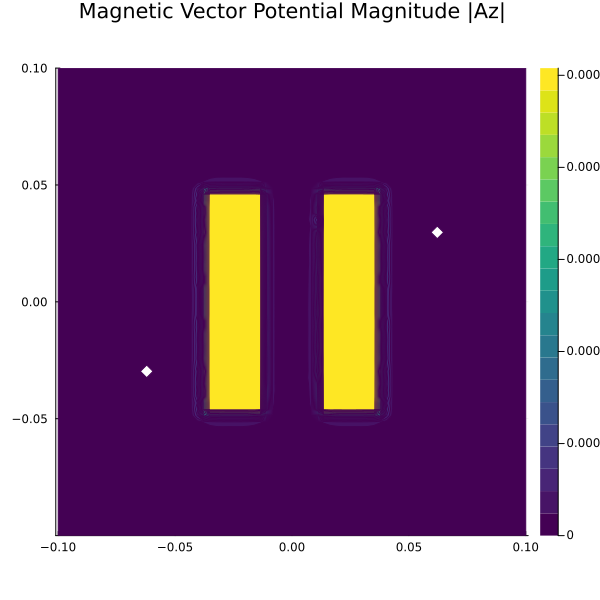

Contour plot saved to /Users/ezracerpac/PycharmProjects/FutureDistributionSystemsAM/examples_2d/output/Az_magnitude_contour.pdf


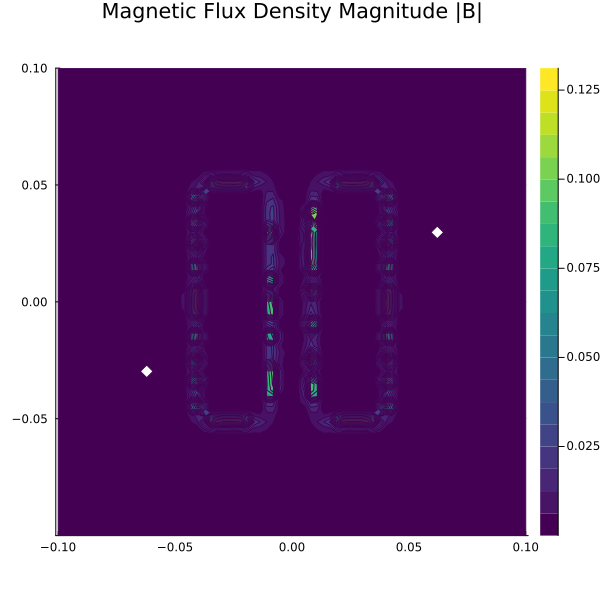

Contour plot saved to /Users/ezracerpac/PycharmProjects/FutureDistributionSystemsAM/examples_2d/output/B_magnitude_contour.pdf


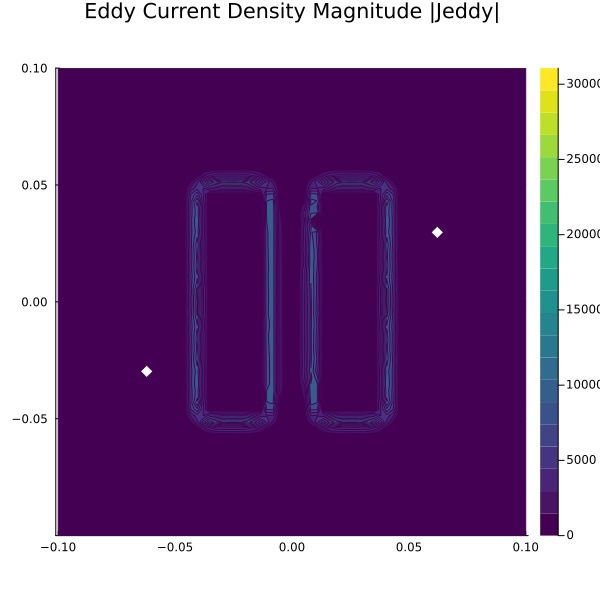

Contour plot saved to /Users/ezracerpac/PycharmProjects/FutureDistributionSystemsAM/examples_2d/output/Jeddy_magnitude_contour.pdf


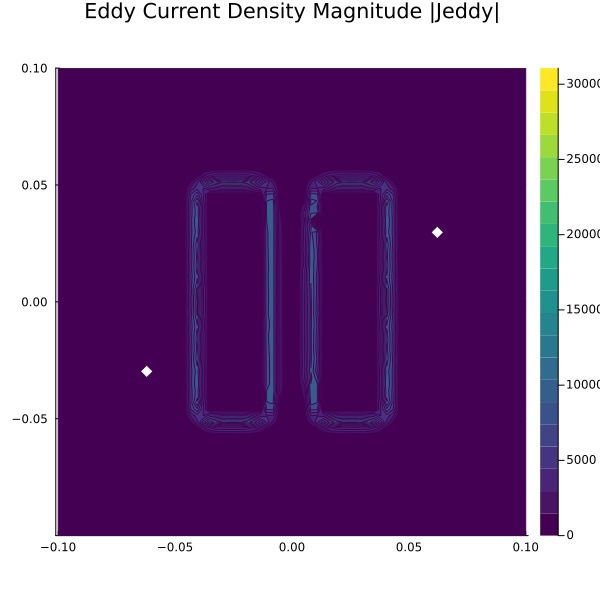

In [12]:
# Plot the magnitude of the magnetic vector potential
plot_contour_2d(Ω, Az_mag, title="Magnetic Vector Potential Magnitude |Az|", output_path=joinpath(paths["OUTPUT_DIR"], "Az_magnitude_contour.pdf"))

# Plot the magnitude of the magnetic flux density
plot_contour_2d(Ω, B_mag, title="Magnetic Flux Density Magnitude |B|", output_path=joinpath(paths["OUTPUT_DIR"], "B_magnitude_contour.pdf"))

# Plot the magnitude of the eddy current density
plot_contour_2d(Ω, Jeddy_mag, title="Eddy Current Density Magnitude |Jeddy|", output_path=joinpath(paths["OUTPUT_DIR"], "Jeddy_magnitude_contour.pdf"))